# Model Checking

After running an MCMC simulation, `sample` returns a `MutliTrace` object containing the samples for all the stochastic and deterministic random variables. The final step in Bayesian computation is model checking, in order to ensure that inferences derived from your sample are valid. There are two components to model checking:

1. Convergence diagnostics
2. Goodness of fit

Convergence diagnostics are intended to detect lack of convergence in the Markov chain Monte Carlo sample; it is used to ensure that you have not halted your sampling too early. However, a converged model is not guaranteed to be a good model. The second component of model checking, goodness of fit, is used to check the internal validity of the model, by comparing predictions from the model to the data used to fit the model. 

## Convergence Diagnostics

Valid inferences from sequences of MCMC samples are based on the
assumption that the samples are derived from the true posterior
distribution of interest. Theory guarantees this condition as the number
of iterations approaches infinity. It is important, therefore, to
determine the **minimum number of samples** required to ensure a reasonable
approximation to the target posterior density. Unfortunately, no
universal threshold exists across all problems, so convergence must be
assessed independently each time MCMC estimation is performed. The
procedures for verifying convergence are collectively known as
*convergence diagnostics*.

One approach to analyzing convergence is **analytical**, whereby the
variance of the sample at different sections of the chain are compared
to that of the limiting distribution. These methods use distance metrics
to analyze convergence, or place theoretical bounds on the sample
variance, and though they are promising, they are generally difficult to
use and are not prominent in the MCMC literature. More common is a
**statistical** approach to assessing convergence. With this approach,
rather than considering the properties of the theoretical target
distribution, only the statistical properties of the observed chain are
analyzed. Reliance on the sample alone restricts such convergence
criteria to **heuristics**. As a result, convergence cannot be guaranteed.
Although evidence for lack of convergence using statistical convergence
diagnostics will correctly imply lack of convergence in the chain, the
absence of such evidence will not *guarantee* convergence in the chain.
Nevertheless, negative results for one or more criteria may provide some
measure of assurance to users that their sample will provide valid
inferences.

For most simple models, convergence will occur quickly, sometimes within
a the first several hundred iterations, after which all remaining
samples of the chain may be used to calculate posterior quantities. For
more complex models, convergence requires a significantly longer burn-in
period; sometimes orders of magnitude more samples are needed.
Frequently, lack of convergence will be caused by **poor mixing**. 
Recall that *mixing* refers to the degree to which the Markov
chain explores the support of the posterior distribution. Poor mixing
may stem from inappropriate proposals (if one is using the
Metropolis-Hastings sampler) or from attempting to estimate models with
highly correlated variables.

In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns; sns.set_context('notebook')

In [2]:
from pymc3 import Normal, Binomial, sample, Model
from pymc3.math import exp

# Samples for each dose level
n = 5 * np.ones(4, dtype=int)
# Log-dose
dose = np.array([-.86, -.3, -.05, .73])
deaths = np.array([0, 1, 3, 5])

def invlogit(x):
    return exp(x) / (1 + exp(x))

with Model() as bioassay_model:

    # Logit-linear model parameters
    alpha = Normal('alpha', 0, 0.01)
    beta = Normal('beta', 0, 0.01)

    # Calculate probabilities of death
    theta = invlogit(alpha + beta * dose)

    # Data likelihood
    deaths = Binomial('deaths', n=n, p=theta, observed=deaths)

In [3]:
from pymc3 import Metropolis

with bioassay_model:
    step = Metropolis(scaling=0.0001)
    bioassay_trace = sample(1000, step=step, init=None)

100%|██████████| 1000/1000 [00:00<00:00, 4069.47it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11045a320>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1137e5f98>]], dtype=object)

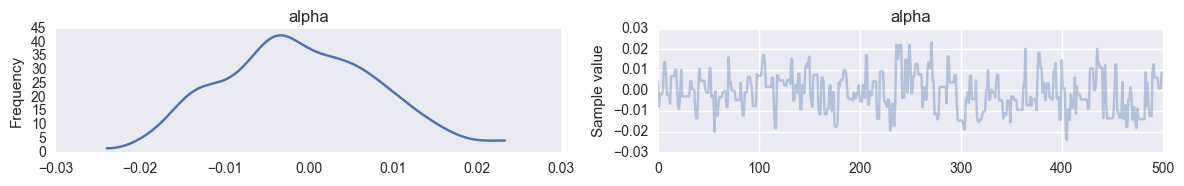

In [4]:
from pymc3 import traceplot

traceplot(bioassay_trace[500:], varnames=['alpha'])

### Informal Methods

The most straightforward approach for assessing convergence is based on
simply **plotting and inspecting traces and histograms** of the observed
MCMC sample. If the trace of values for each of the stochastics exhibits
asymptotic behavior over the last $m$ iterations, this may be
satisfactory evidence for convergence. 

Assigned NUTS to alpha
Assigned NUTS to beta
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
100%|██████████| 10000/10000 [00:04<00:00, 2091.18it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114cd6d30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x114cf44a8>]], dtype=object)

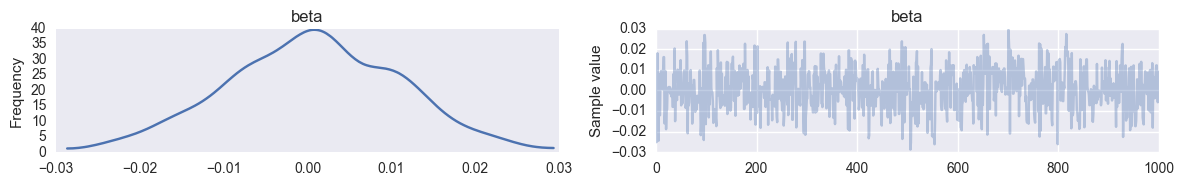

In [5]:
with bioassay_model:
    bioassay_trace = sample(10000, init=None)
    
traceplot(bioassay_trace[9000:], varnames=['beta'])

A similar approach involves
plotting a histogram for every set of $k$ iterations (perhaps 50-100)
beyond some burn in threshold $n$; if the histograms are not visibly
different among the sample intervals, this may be considered some evidence for
convergence. Note that such diagnostics should be carried out for each
stochastic estimated by the MCMC algorithm, because convergent behavior
by one variable does not imply evidence for convergence for other
variables in the analysis. 

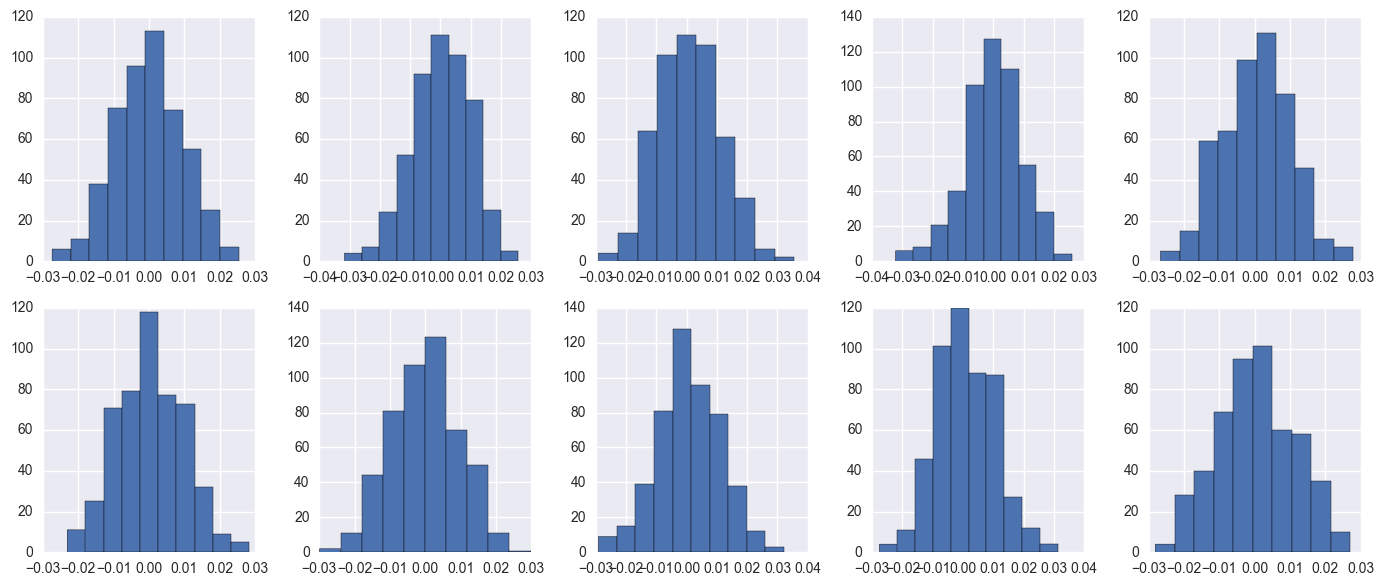

In [6]:
import matplotlib.pyplot as plt

beta_trace = bioassay_trace['beta']

fig, axes = plt.subplots(2, 5, figsize=(14,6))
axes = axes.ravel()
for i in range(10):
    axes[i].hist(beta_trace[500*i:500*(i+1)])
plt.tight_layout()

An extension of this approach can be taken
when multiple parallel chains are run, rather than just a single, long
chain. In this case, the final values of $c$ chains run for $n$
iterations are plotted in a histogram; just as above, this is repeated
every $k$ iterations thereafter, and the histograms of the endpoints are
plotted again and compared to the previous histogram. This is repeated
until consecutive histograms are indistinguishable.

Another *ad hoc* method for detecting lack of convergence is to examine
the traces of several MCMC chains initialized with different starting
values. Overlaying these traces on the same set of axes should (if
convergence has occurred) show each chain tending toward the same
equilibrium value, with approximately the same variance. Recall that the
tendency for some Markov chains to converge to the true (unknown) value
from diverse initial values is called *ergodicity*. This property is
guaranteed by the reversible chains constructed using MCMC, and should
be observable using this technique. Again, however, this approach is
only a heuristic method, and cannot always detect lack of convergence,
even though chains may appear ergodic.

In [20]:
with bioassay_model:
    
    bioassay_trace = sample(20000, njobs=2, step=Metropolis(), start=[{'alpha':1.}, {'alpha':3.}], init='MAP')

100%|██████████| 20000/20000 [00:06<00:00, 2947.44it/s]


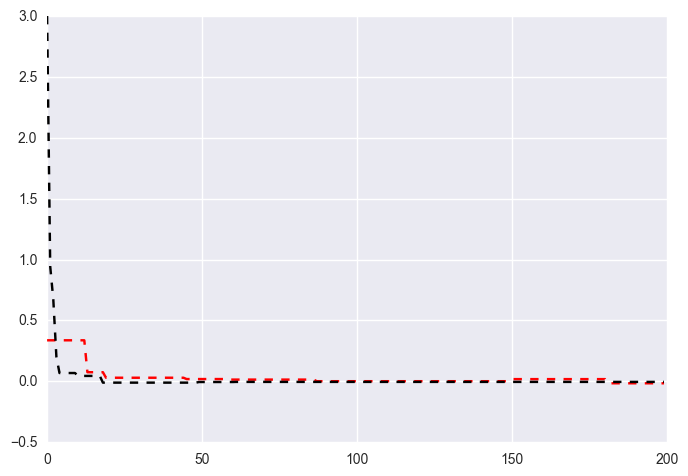

In [21]:
plt.plot(bioassay_trace.get_values('alpha', chains=0)[:200], 'r--')
plt.plot(bioassay_trace.get_values('alpha', chains=1)[:200], 'k--')

A principal reason that evidence from informal techniques cannot
guarantee convergence is a phenomenon called ***metastability***. Chains may
appear to have converged to the true equilibrium value, displaying
excellent qualities by any of the methods described above. However,
after some period of stability around this value, the chain may suddenly
move to another region of the parameter space. This period
of metastability can sometimes be very long, and therefore escape
detection by these convergence diagnostics. Unfortunately, there is no
statistical technique available for detecting metastability.

### Formal Methods

Along with the *ad hoc* techniques described above, a number of more
formal methods exist which are prevalent in the literature. These are
considered more formal because they are based on existing statistical
methods, such as time series analysis.

PyMC currently includes three formal convergence diagnostic methods. The
first, proposed by [Geweke (1992)](http://projecteuclid.org/DPubS?service=UI&version=1.0&verb=Display&handle=euclid.ss/1177011446), is a time-series approach that
compares the mean and variance of segments from the beginning and end of
a single chain.

$$z = \frac{\bar{\theta}_a - \bar{\theta}_b}{\sqrt{S_a(0) + S_b(0)}}$$

where $a$ is the early interval and $b$ the late interval, and $S_i(0)$ is the spectral density estimate at zero frequency for chain segment $i$. If the
z-scores (theoretically distributed as standard normal variates) of
these two segments are similar, it can provide evidence for convergence.
PyMC calculates z-scores of the difference between various initial
segments along the chain, and the last 50% of the remaining chain. If
the chain has converged, the majority of points should fall within 2
standard deviations of zero.

In PyMC, diagnostic z-scores can be obtained by calling the `geweke` function. It
accepts either (1) a single trace, (2) a Node or Stochastic object, or
(4) an entire Model object:

In [27]:
foo = {'alpha': 1}

In [26]:
bioassay_model['alpha'].dtype

'float64'

In [30]:
a = bioassay_model['alpha']

In [39]:
def typecast(var, val):
    if var.dtype.startswith('float'):
        return 

'float64'

In [41]:
np.array(1, 'float64')

array(1.0)

In [42]:
{s for s in foo}

{'alpha'}

In [14]:
from pymc3 import geweke

with bioassay_model:
    tr = sample(2000)
    
z = geweke(tr, intervals=15)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -9.98: 100%|██████████| 200000/200000 [00:13<00:00, 14679.56it/s]  
Finished [100%]: Average ELBO = -9.9824
100%|██████████| 2000/2000 [00:01<00:00, 1234.24it/s]


(0, 1000)

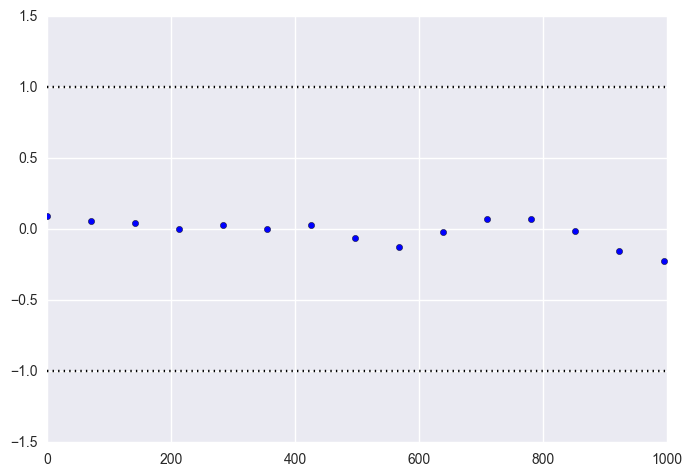

In [15]:
plt.scatter(*z['alpha'].T)
plt.hlines([-1,1], 0, 1000, linestyles='dotted')
plt.xlim(0, 1000)

The arguments expected are the following:

- `x` : The trace of a variable.
- `first` : The fraction of series at the beginning of the trace.
- `last` : The fraction of series at the end to be compared with the section at the beginning.
- `intervals` : The number of segments.

Plotting the output displays the scores in series, making it is easy to
see departures from the standard normal assumption.

A second convergence diagnostic provided by PyMC is the Gelman-Rubin
statistic [Gelman and Rubin (1992)](http://projecteuclid.org/DPubS?service=UI&version=1.0&verb=Display&handle=euclid.ss/1177011136). This diagnostic uses multiple chains to
check for lack of convergence, and is based on the notion that if
multiple chains have converged, by definition they should appear very
similar to one another; if not, one or more of the chains has failed to
converge.

The Gelman-Rubin diagnostic uses an analysis of variance approach to
assessing convergence. That is, it calculates both the between-chain
varaince (B) and within-chain varaince (W), and assesses whether they
are different enough to worry about convergence. Assuming $m$ chains,
each of length $n$, quantities are calculated by:

$$\begin{align}B &= \frac{n}{m-1} \sum_{j=1}^m (\bar{\theta}_{.j} - \bar{\theta}_{..})^2 \\
W &= \frac{1}{m} \sum_{j=1}^m \left[ \frac{1}{n-1} \sum_{i=1}^n (\theta_{ij} - \bar{\theta}_{.j})^2 \right]
\end{align}$$

for each scalar estimand $\theta$. Using these values, an estimate of
the marginal posterior variance of $\theta$ can be calculated:

$$\hat{\text{Var}}(\theta | y) = \frac{n-1}{n} W + \frac{1}{n} B$$

Assuming $\theta$ was initialized to arbitrary starting points in each
chain, this quantity will overestimate the true marginal posterior
variance. At the same time, $W$ will tend to underestimate the
within-chain variance early in the sampling run. However, in the limit
as $n \rightarrow 
\infty$, both quantities will converge to the true variance of $\theta$.
In light of this, the Gelman-Rubin statistic monitors convergence using
the ratio:

$$\hat{R} = \sqrt{\frac{\hat{\text{Var}}(\theta | y)}{W}}$$

This is called the potential scale reduction, since it is an estimate of
the potential reduction in the scale of $\theta$ as the number of
simulations tends to infinity. In practice, we look for values of
$\hat{R}$ close to one (say, less than 1.1) to be confident that a
particular estimand has converged. In PyMC, the function
`gelman_rubin` will calculate $\hat{R}$ for each stochastic node in
the passed model:

In [22]:
from pymc3 import gelman_rubin

gelman_rubin(bioassay_trace)

{'alpha': 1.0000175040825041, 'beta': 1.0002776424151445}

For the best results, each chain should be initialized to highly
dispersed starting values for each stochastic node.

By default, when calling the `forestplot` function using nodes with
multiple chains, the $\hat{R}$ values will be plotted alongside the
posterior intervals.

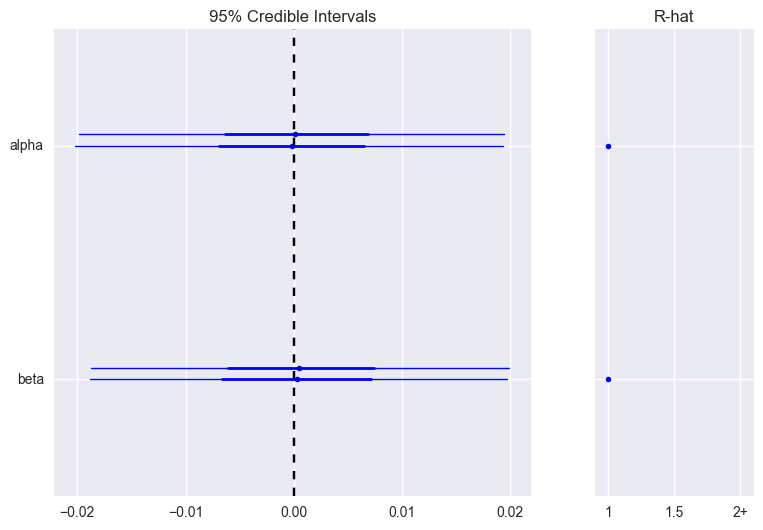

In [23]:
from pymc3 import forestplot

forestplot(bioassay_trace)

## Autocorrelation

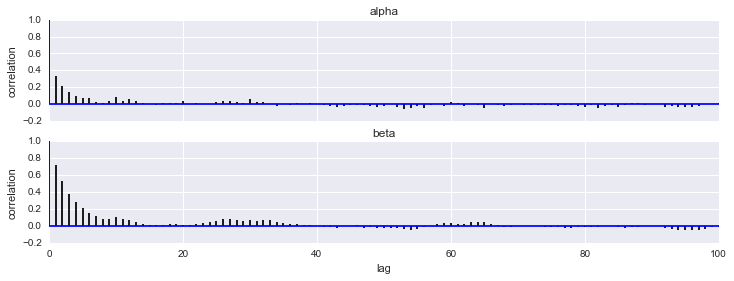

In [14]:
from pymc3 import autocorrplot

autocorrplot(tr);

In [15]:
bioassay_trace['alpha'].shape

(2000,)

In [16]:
from pymc3 import effective_n

effective_n(bioassay_trace)

{'alpha': 292, 'beta': 177}

## Goodness of Fit

Checking for model convergence is only the first step in the evaluation
of MCMC model outputs. It is possible for an entirely unsuitable model
to converge, so additional steps are needed to ensure that the estimated
model adequately fits the data. One intuitive way of evaluating model
fit is to compare model predictions with the observations used to fit
the model. In other words, the fitted model can be used to simulate
data, and the distribution of the simulated data should resemble the
distribution of the actual data.

Fortunately, simulating data from the model is a natural component of
the Bayesian modelling framework. Recall, from the discussion on
imputation of missing data, the posterior predictive distribution:

$$p(\tilde{y}|y) = \int p(\tilde{y}|\theta) f(\theta|y) d\theta$$

Here, $\tilde{y}$ represents some hypothetical new data that would be
expected, taking into account the posterior uncertainty in the model
parameters. Sampling from the posterior predictive distribution is easy
in PyMC. The code looks identical to the corresponding data stochastic,
with two modifications: (1) the node should be specified as
deterministic and (2) the statistical likelihoods should be replaced by
random number generators. Consider the `gelman_bioassay` example, 
where deaths are modeled as a binomial random variable for which
the probability of death is a logit-linear function of the dose of a
particular drug.

In [17]:
from pymc3 import Normal, Binomial, Deterministic, invlogit

# Samples for each dose level
n = 5 * np.ones(4, dtype=int)
# Log-dose
dose = np.array([-.86, -.3, -.05, .73])

with Model() as model:

    # Logit-linear model parameters
    alpha = Normal('alpha', 0, 0.01)
    beta = Normal('beta', 0, 0.01)

    # Calculate probabilities of death
    theta = Deterministic('theta', invlogit(alpha + beta * dose))

    # Data likelihood
    deaths = Binomial('deaths', n=n, p=theta, observed=[0, 1, 3, 5])

The posterior predictive distribution of deaths uses the same functional
form as the data likelihood, in this case a binomial stochastic. Here is
the corresponding sample from the posterior predictive distribution:

In [18]:
with model:
    
    deaths_sim = Binomial('deaths_sim', n=n, p=theta, shape=4)

Notice that the observed stochastic `Binomial` has been replaced with a stochastic node that is identical in every respect to `deaths`, except that its values are not fixed to be the observed data -- they are left to vary according to the values of the fitted parameters.

The degree to which simulated data correspond to observations can be evaluated in at least two ways. First, these quantities can simply be compared visually. This allows for a qualitative comparison of model-based replicates and observations. If there is poor fit, the true value of the data may appear in the tails of the histogram of replicated data, while a good fit will tend to show the true data in high-probability regions of the posterior predictive distribution. The Matplot package in PyMC provides an easy way of producing such plots, via the `gof_plot` function.

In [19]:
with model:
    
    gof_trace = sample(2000)

Assigned NUTS to alpha
Assigned NUTS to beta
Assigned Metropolis to deaths_sim
 [-----------------100%-----------------] 2000 of 2000 complete in 1.8 sec

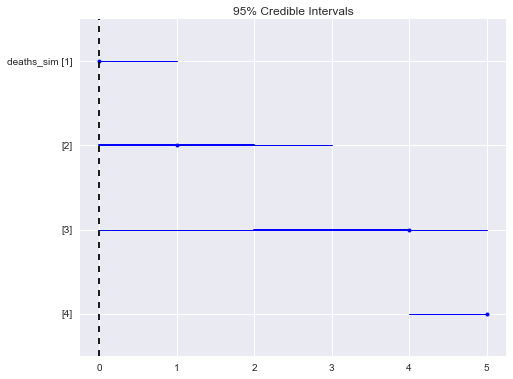

In [20]:
from pymc3 import forestplot

forestplot(gof_trace, varnames=['deaths_sim'])

## Exercise: Meta-analysis of beta blocker effectiveness

Carlin (1992) considers a Bayesian approach to meta-analysis, and includes the following examples of 22 trials of beta-blockers to prevent mortality after myocardial infarction.

In a random effects meta-analysis we assume the true effect (on a log-odds scale) $d_i$ in a trial $i$
is drawn from some population distribution. Let $r^C_i$ denote number of events in the control group in trial $i$,
and $r^T_i$ denote events under active treatment in trial $i$. Our model is:

$$\begin{aligned}
r^C_i &\sim \text{Binomial}\left(p^C_i, n^C_i\right) \\
r^T_i &\sim \text{Binomial}\left(p^T_i, n^T_i\right) \\
\text{logit}\left(p^C_i\right) &= \mu_i \\
\text{logit}\left(p^T_i\right) &= \mu_i + \delta_i \\
\delta_i &\sim \text{Normal}(d, t) \\
\mu_i &\sim \text{Normal}(m, s)
\end{aligned}$$

We want to make inferences about the population effect $d$, and the predictive distribution for the effect $\delta_{\text{new}}$ in a new trial. Build a model to estimate these quantities in PyMC, and (1) use convergence diagnostics to check for convergence and (2) use posterior predictive checks to assess goodness-of-fit.

Here are the data:

In [21]:
r_t_obs = [3, 7, 5, 102, 28, 4, 98, 60, 25, 138, 64, 45, 9, 57, 25, 33, 28, 8, 6, 32, 27, 22]
n_t_obs = [38, 114, 69, 1533, 355, 59, 945, 632, 278,1916, 873, 263, 291, 858, 154, 207, 251, 151, 174, 209, 391, 680]
r_c_obs = [3, 14, 11, 127, 27, 6, 152, 48, 37, 188, 52, 47, 16, 45, 31, 38, 12, 6, 3, 40, 43, 39]
n_c_obs = [39, 116, 93, 1520, 365, 52, 939, 471, 282, 1921, 583, 266, 293, 883, 147, 213, 122, 154, 134, 218, 364, 674]
N = len(n_c_obs)

In [22]:
# Write your answer here

## References

Gelman, A., & Rubin, D. B. (1992). Inference from iterative simulation using multiple sequences. Statistical Science. A Review Journal of the Institute of Mathematical Statistics, 457–472.

Geweke, J., Berger, J. O., & Dawid, A. P. (1992). Evaluating the accuracy of sampling-based approaches to the calculation of posterior moments. In Bayesian Statistics 4.

Brooks, S. P., Catchpole, E. A., & Morgan, B. J. T. (2000). Bayesian Animal Survival Estimation. Statistical Science. A Review Journal of the Institute of Mathematical Statistics, 15(4), 357–376. doi:10.1214/ss/1177010123

Gelman, A., Meng, X., & Stern, H. (1996). Posterior predicitive assessment of model fitness via realized discrepencies with discussion. Statistica Sinica, 6, 733–807.

Raftery, A., & Lewis, S. (1992). One long run with diagnostics: Implementation strategies for Markov chain Monte Carlo. Statistical Science. A Review Journal of the Institute of Mathematical Statistics, 7, 493–497.

[CrossValidated: How to use scikit-learn's cross validation functions on multi-label classifiers](http://stats.stackexchange.com/questions/65828/how-to-use-scikit-learns-cross-validation-functions-on-multi-label-classifiers)